# Training Encoder Decoder Model

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

In [2]:
df= pd.read_csv("/content/cleaned.csv")

In [3]:
df.tail()

,English,Marathi,en_word_count,mar_word_count,mar_char_count,en_char_count
46990,just saying you do not like fish because of th...,हड्डींमुळे मासे आवडत नाही असं म्हणणं हे काय मा...,21,13,68,81
46991,tom tried to sell his old vcr instead of throw...,टॉमने त्याचा जुना व्हीसीआर फेकून टाकण्याऐवजी व...,25,23,129,89
46992,january february march april may june july aug...,जानेवारी फेब्रुवारी मार्च एप्रिल मे जून जुलै ऑ...,20,18,97,104
46993,you cannot view flash content on an ipad howev...,आयपॅडवर फ्लॅश आशय बघता येत नाही पण तुम्ही त्या...,32,24,118,140
46994,in roger miller recorded a song called you do...,मध्ये रॉजर मिलरने यू डोन्ट वॉन्ट माय लव्ह नावा...,36,35,149,140


**Note** this data was cleaned at notebook of EDA_And_Cleaning_Text

# Prepare dataset for encoder decoder model
## Encoder:-
* convert text into numbers
* [WordEmbedding](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/):- Then embedding is very important layer for beause it will convert the input word-`numbers into more dimension of vectors which will have semantic information words means beause of this we can know which words are similar or near to each other.`
* We will not take output of timestamps of encoder beause it will be like one to one mapping so we will just take selt states of encoder as context vector.

## Decoder:-
* First most important thing is we have to add special tokens in each target language at start SOS and EOS at end reason of this is `The length of translated sentence might not be same as other language so it is to tell model where is start and end of sentence.`
* When building model we will provide initial state of model as context vector recived from Encoder.


#### Fisrt add eos and sos tokens
* SOS = Start Of String
* EOS = End Of String

In [4]:
df.Marathi = df.Marathi.apply(lambda x: 'sos '+ x +' eos')

### create vocabulary of english and marathi words

In [5]:
eng_vocab= set()
for sent in df.English:
    for word in sent.split():
        if word not in eng_vocab:
            eng_vocab.add(word)

In [6]:
mar_vocab= set()
for sent in df.Marathi:
    for word in sent.split():
        if word not in mar_vocab:
            mar_vocab.add(word)

In [7]:
len(eng_vocab), len(mar_vocab),

(5787, 14389)

In [8]:
# for zero padding add 1 in them
ENG_VOCAB_SIZE= len(eng_vocab)+1
MAR_VOCAB_SIZE= len(mar_vocab)+1
print(ENG_VOCAB_SIZE)
print(MAR_VOCAB_SIZE)


5788
14390


### Create dictionary for words and their indexes then we can convert text into numbers

#### First we need sorted words list

In [9]:
eng_words = sorted(list(eng_vocab))
mar_words = sorted(list(mar_vocab))

#### Word to number

In [10]:
# create english and marathi dicts
eng_word_index = dict((w, i) for i, w in enumerate(eng_words))
mar_word_index = dict((w, i) for i, w in enumerate(mar_words))

In [ ]:
mar_word_index

#### Number to word
*  we will need this one at time of creating text from predicted values

In [12]:
eng_index_word = dict((i, w) for i, w in enumerate(eng_words))
mar_index_word = dict((i,w) for i, w in enumerate(mar_words))

In [ ]:
mar_index_word

### Train test split

In [14]:
X_train, X_test, y_train, y_test= train_test_split(df.English, df.Marathi, test_size=0.2, random_state=0)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37596,), (9399,), (37596,), (9399,))

## Create data generator
* if we create array of 3d shape with our vocab size this will give us out of memmory error
* And it is always best to use batches to train it will make process faster
* Insted of passing all data in model which may run out of memory we create data generator which will create data batches at time of training

#### prepare input for encoder decoder [refer](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)
* Turn the sentences into 3 Numpy arrays, encoder_input_data, decoder_input_data, decoder_target_data:
>* encoder_input_data is a 3D array of shape (num_pairs,max_english_sentence_length, num_english_characters) containing a one-hot vectorization of the English sentences.
>* decoder_input_data is a 3D array of shape (num_pairs, max_french_sentence_length, num_french_characters) containg a one-hot vectorization of the French sentences.
>* decoder_target_data is the same as decoder_input_data but offset by one timestep. decoder_target_data[:, t, :] will be the same as decoder_input_data[:, t + 1, :].
* 2) Train a basic LSTM-based Seq2Seq model to predict decoder_target_data given encoder_input_data and decoder_input_data. Our model uses teacher forcing.
* 3) Decode some sentences to check that the model is working (i.e. turn samples from encoder_input_data into corresponding samples from decoder_target_data).

* We use a technique called “Teacher Forcing” wherein the input at each time step is given as the actual output (and not the predicted output) from the previous time step.

#### Before we go ahead lets define some things we need for data generator

In [16]:
### Get lengths of each sentence in list
eng_len_list=df.English.apply(lambda x: len(x.split())).to_list()

mar_len_list=df.Marathi.apply(lambda x: len(x.split())).to_list()


In [17]:
# get max length
np.max(mar_len_list), np.max(eng_len_list)

(37, 36)

In [18]:
BATCH_SIZE= 64
max_eng_len =  np.max(eng_len_list)
max_mar_len =  np.max(mar_len_list)

In [19]:
max_eng_len, max_mar_len

(36, 37)

In [20]:
def data_batch_generator(x, y, batch_size=BATCH_SIZE):
    while True:
        for i in range(0, len(x), batch_size):
            encoder_input_data = np.zeros((batch_size,max_eng_len ), dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_mar_len), dtype='float32')
            # one hot encoded target data beause dense layer with softmax will give only one output at a time
            decoder_target_data = np.zeros((batch_size, max_mar_len, MAR_VOCAB_SIZE), dtype='float32' )
            for j, (eng_text, mar_text) in enumerate(zip(x[i:i+batch_size], y[i:i+batch_size])):
                for t , word in enumerate(eng_text.split()):
                    encoder_input_data[j,t] = eng_word_index[word]
                for t, word in enumerate(mar_text.split()):
                    if t < len(mar_text.split()) - 1:
                        decoder_input_data[j,t]= mar_word_index[word]
                    if t>0:
                        # This is decoder target output which is one step ahead of decoder input
                        # it does not have EOS token
                        decoder_target_data[j,t-1, mar_word_index[word]] = 1.
            yield ([encoder_input_data, decoder_input_data], decoder_target_data)


# LSTM Encoder Decoder Model

In [21]:
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding
from tensorflow.keras import Input, Model

In [22]:
# Eoncoder
encoder_input = Input(shape=(None, ))
encoder_embd = Embedding(ENG_VOCAB_SIZE,100, mask_zero=True)(encoder_input)
encoder_lstm = LSTM(100, return_state=True)
encoder_output,state_h, state_c = encoder_lstm(encoder_embd)

## Now take only states and create context vector
encoder_states= [state_h, state_c]

# Decoder
decoder_input = Input(shape=(None,))
# For zero padding we have added +1 in marathi vocab size
decoder_embd = Embedding(MAR_VOCAB_SIZE, 100, mask_zero=True)
decoder_embedding= decoder_embd(decoder_input)
decoder_lstm = LSTM(100, return_state=True,return_sequences=True )
# just take output of this decoder dont need self states
decoder_outputs, _, _= decoder_lstm(decoder_embedding, initial_state=encoder_states)
# here this is going to predicct so we can add dense layer here
# here we want to convert predicted numbers into probability so use softmax
decoder_dense= Dense(MAR_VOCAB_SIZE, activation='softmax')
# We will again feed predicted output into decoder to predict its next word
decoder_outputs = decoder_dense(decoder_outputs)

model1 = Model([encoder_input, decoder_input], decoder_outputs)

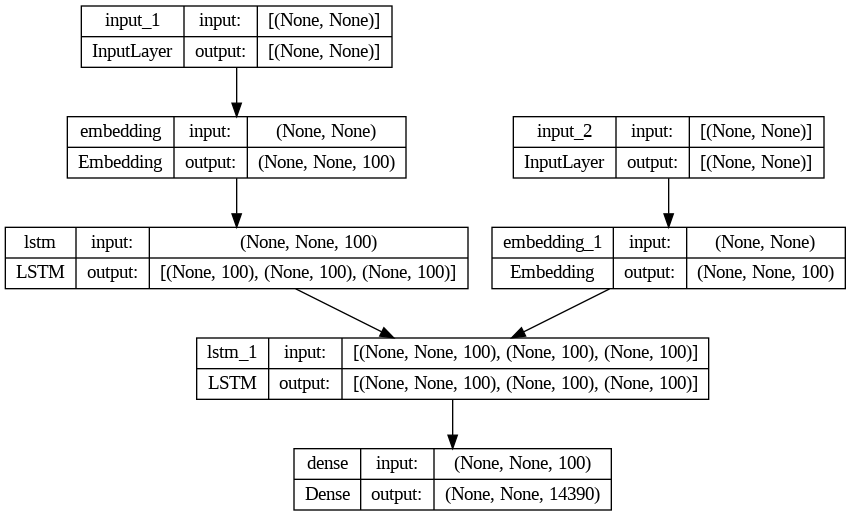

In [23]:
from tensorflow.keras.utils import  plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
plot_model(model1,show_shapes=True)

In [ ]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
checkpoint = ModelCheckpoint("/content/model_checkpoints/", monitor='val_accuracy')

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

callbacks_list = [checkpoint, early_stopping]

#### to avoid unknown samples need to use sptes per epoch else model will fit for infinite samples

In [ ]:
steps_per_epoch= np.ceil(len(X_train)/BATCH_SIZE)
steps_per_epoch_val = np.ceil(len(X_train)/BATCH_SIZE)

In [ ]:
steps_per_epoch

588.0

In [ ]:
EPOCHS= 30 #@param {type:'slider',min:10,max:100, step:10 }
EPOCHS

30

In [ ]:
history1= model1.fit(data_batch_generator(X_train,y_train),
                       epochs=EPOCHS,
                       steps_per_epoch= steps_per_epoch,
                     validation_data=data_batch_generator(X_test, y_test, BATCH_SIZE),
                       validation_steps=steps_per_epoch_val,
                     callbacks=callbacks_list)

Epoch 1/30
588/588 [==============================] - ETA: 0s - loss: 6.0162 - accuracy: 0.1976

588/588 [==============================] - 380s 621ms/step - loss: 6.0162 - accuracy: 0.1976 - val_loss: 5.4789 - val_accuracy: 0.2191
Epoch 2/30
588/588 [==============================] - ETA: 0s - loss: 5.1496 - accuracy: 0.2502

588/588 [==============================] - 307s 522ms/step - loss: 5.1496 - accuracy: 0.2502 - val_loss: 4.9967 - val_accuracy: 0.2732
Epoch 3/30
588/588 [==============================] - ETA: 0s - loss: 4.6279 - accuracy: 0.2985

588/588 [==============================] - 337s 573ms/step - loss: 4.6279 - accuracy: 0.2985 - val_loss: 4.5702 - val_accuracy: 0.3252
Epoch 4/30
588/588 [==============================] - ETA: 0s - loss: 4.1319 - accuracy: 0.3509

588/588 [==============================] - 295s 502ms/step - loss: 4.1319 - accuracy: 0.3509 - val_loss: 4.2014 - val_accuracy: 0.3674
Epoch 5/30
588/588 [==============================] - ETA: 0s - loss: 3.6967 - accuracy: 0.3946

588/588 [==============================] - 290s 493ms/step - loss: 3.6967 - accuracy: 0.3946 - val_loss: 3.9066 - val_accuracy: 0.3982
Epoch 6/30
588/588 [==============================] - ETA: 0s - loss: 3.3220 - accuracy: 0.4318

588/588 [==============================] - 328s 558ms/step - loss: 3.3220 - accuracy: 0.4318 - val_loss: 3.6635 - val_accuracy: 0.4247
Epoch 7/30
588/588 [==============================] - ETA: 0s - loss: 2.9867 - accuracy: 0.4671

588/588 [==============================] - 288s 490ms/step - loss: 2.9867 - accuracy: 0.4671 - val_loss: 3.4652 - val_accuracy: 0.4468
Epoch 8/30
588/588 [==============================] - ETA: 0s - loss: 2.6888 - accuracy: 0.5012

588/588 [==============================] - 286s 487ms/step - loss: 2.6888 - accuracy: 0.5012 - val_loss: 3.2917 - val_accuracy: 0.4700
Epoch 9/30
588/588 [==============================] - ETA: 0s - loss: 2.4211 - accuracy: 0.5348

588/588 [==============================] - 288s 491ms/step - loss: 2.4211 - accuracy: 0.5348 - val_loss: 3.1463 - val_accuracy: 0.4898
Epoch 10/30
588/588 [==============================] - ETA: 0s - loss: 2.1800 - accuracy: 0.5680

588/588 [==============================] - 325s 553ms/step - loss: 2.1800 - accuracy: 0.5680 - val_loss: 3.0269 - val_accuracy: 0.5074
Epoch 11/30
588/588 [==============================] - ETA: 0s - loss: 1.9636 - accuracy: 0.5990

588/588 [==============================] - 326s 555ms/step - loss: 1.9636 - accuracy: 0.5990 - val_loss: 2.9261 - val_accuracy: 0.5206
Epoch 12/30
588/588 [==============================] - ETA: 0s - loss: 1.7706 - accuracy: 0.6291

588/588 [==============================] - 326s 556ms/step - loss: 1.7706 - accuracy: 0.6291 - val_loss: 2.8387 - val_accuracy: 0.5332
Epoch 13/30
588/588 [==============================] - ETA: 0s - loss: 1.5976 - accuracy: 0.6580

588/588 [==============================] - 325s 553ms/step - loss: 1.5976 - accuracy: 0.6580 - val_loss: 2.7719 - val_accuracy: 0.5451
Epoch 14/30
588/588 [==============================] - ETA: 0s - loss: 1.4419 - accuracy: 0.6856

In [ ]:
model1.save_weights('/content/model1_weights.h5')

In [ ]:
model1.load_weights('/content/model1_weights.h5')

# Model2
Now we will try to improve its accurcy with changing some units

In [31]:
# Eoncoder
encoder_input = Input(shape=(None, ))
encoder_embd = Embedding(ENG_VOCAB_SIZE,1000, mask_zero=True)(encoder_input)
encoder_lstm = LSTM(250, return_state=True)
encoder_output,state_h, state_c = encoder_lstm(encoder_embd)

## Now take only states and create context vector
encoder_states= [state_h, state_c]

# Decoder
decoder_input = Input(shape=(None,))
# For zero padding we have added +1 in marathi vocab size
decoder_embd = Embedding(MAR_VOCAB_SIZE, 1000, mask_zero=True)
decoder_embedding= decoder_embd(decoder_input)
decoder_lstm = LSTM(250, return_state=True,return_sequences=True )
# just take output of this decoder dont need self states
decoder_outputs, _, _= decoder_lstm(decoder_embedding, initial_state=encoder_states)
# here this is going to predicct so we can add dense layer here
# here we want to convert predicted numbers into probability so use softmax
decoder_dense= Dense(MAR_VOCAB_SIZE, activation='softmax')
# We will again feed predicted output into decoder to predict its next word
decoder_outputs = decoder_dense(decoder_outputs)

model2 = Model([encoder_input, decoder_input], decoder_outputs)

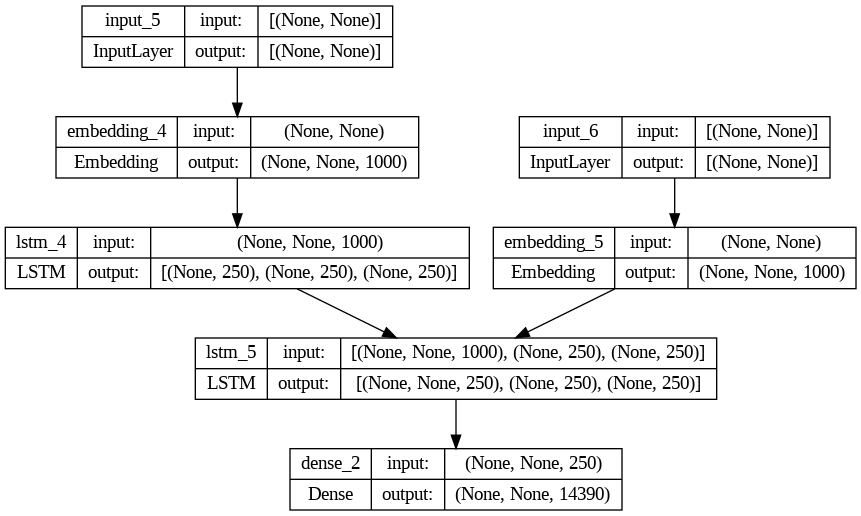

In [32]:
from tensorflow.keras.utils import  plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
plot_model(model2,show_shapes=True)

In [33]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [34]:
checkpoint = ModelCheckpoint("/content/model_checkpoints/model2/", monitor='val_accuracy')

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

callbacks_list = [checkpoint, early_stopping]

In [35]:
steps_per_epoch= np.ceil(len(X_train)/BATCH_SIZE)
steps_per_epoch_val = np.ceil(len(X_train)/BATCH_SIZE)

In [36]:
EPOCHS= 30 #@param {type:'slider',min:10,max:100, step:10 }
EPOCHS

30

In [37]:
history2= model2.fit(data_batch_generator(X_train,y_train),
                       epochs=EPOCHS,
                       steps_per_epoch= steps_per_epoch,
                     validation_data=data_batch_generator(X_test, y_test, BATCH_SIZE),
                       validation_steps=steps_per_epoch_val,
                     callbacks=callbacks_list)

Epoch 1/30
588/588 [==============================] - ETA: 0s - loss: 5.6318 - accuracy: 0.2232

588/588 [==============================] - 338s 559ms/step - loss: 5.6318 - accuracy: 0.2232 - val_loss: 4.9224 - val_accuracy: 0.2734
Epoch 2/30
588/588 [==============================] - ETA: 0s - loss: 4.2389 - accuracy: 0.3482

588/588 [==============================] - 316s 538ms/step - loss: 4.2389 - accuracy: 0.3482 - val_loss: 3.8951 - val_accuracy: 0.4053
Epoch 3/30
588/588 [==============================] - ETA: 0s - loss: 3.1803 - accuracy: 0.4625

588/588 [==============================] - 305s 518ms/step - loss: 3.1803 - accuracy: 0.4625 - val_loss: 3.2095 - val_accuracy: 0.4857
Epoch 4/30
588/588 [==============================] - ETA: 0s - loss: 2.3810 - accuracy: 0.5578

588/588 [==============================] - 317s 539ms/step - loss: 2.3810 - accuracy: 0.5578 - val_loss: 2.7854 - val_accuracy: 0.5405
Epoch 5/30
588/588 [==============================] - ETA: 0s - loss: 1.7857 - accuracy: 0.6388

588/588 [==============================] - 351s 598ms/step - loss: 1.7857 - accuracy: 0.6388 - val_loss: 2.5091 - val_accuracy: 0.5797
Epoch 6/30
588/588 [==============================] - ETA: 0s - loss: 1.3384 - accuracy: 0.7098

588/588 [==============================] - 349s 594ms/step - loss: 1.3384 - accuracy: 0.7098 - val_loss: 2.3367 - val_accuracy: 0.6079
Epoch 7/30
588/588 [==============================] - ETA: 0s - loss: 1.0079 - accuracy: 0.7685

588/588 [==============================] - 347s 591ms/step - loss: 1.0079 - accuracy: 0.7685 - val_loss: 2.2425 - val_accuracy: 0.6259
Epoch 8/30
588/588 [==============================] - ETA: 0s - loss: 0.7671 - accuracy: 0.8156

588/588 [==============================] - 316s 537ms/step - loss: 0.7671 - accuracy: 0.8156 - val_loss: 2.1864 - val_accuracy: 0.6378
Epoch 9/30
588/588 [==============================] - ETA: 0s - loss: 0.5968 - accuracy: 0.8492

588/588 [==============================] - 351s 598ms/step - loss: 0.5968 - accuracy: 0.8492 - val_loss: 2.1568 - val_accuracy: 0.6433
Epoch 10/30
588/588 [==============================] - ETA: 0s - loss: 0.4807 - accuracy: 0.8712

588/588 [==============================] - 345s 586ms/step - loss: 0.4807 - accuracy: 0.8712 - val_loss: 2.1585 - val_accuracy: 0.6454
Epoch 11/30
588/588 [==============================] - ETA: 0s - loss: 0.3981 - accuracy: 0.8872

588/588 [==============================] - 344s 586ms/step - loss: 0.3981 - accuracy: 0.8872 - val_loss: 2.1652 - val_accuracy: 0.6494
Epoch 12/30
588/588 [==============================] - ETA: 0s - loss: 0.3392 - accuracy: 0.8985

588/588 [==============================] - 309s 525ms/step - loss: 0.3392 - accuracy: 0.8985 - val_loss: 2.2014 - val_accuracy: 0.6472
Epoch 13/30
588/588 [==============================] - ETA: 0s - loss: 0.2962 - accuracy: 0.9068

588/588 [==============================] - 309s 526ms/step - loss: 0.2962 - accuracy: 0.9068 - val_loss: 2.2079 - val_accuracy: 0.6524
Epoch 14/30
588/588 [==============================] - ETA: 0s - loss: 0.2601 - accuracy: 0.9149

588/588 [==============================] - 314s 533ms/step - loss: 0.2601 - accuracy: 0.9149 - val_loss: 2.2402 - val_accuracy: 0.6506
Epoch 15/30
588/588 [==============================] - ETA: 0s - loss: 0.2336 - accuracy: 0.9204

588/588 [==============================] - 313s 533ms/step - loss: 0.2336 - accuracy: 0.9204 - val_loss: 2.2667 - val_accuracy: 0.6500
Epoch 16/30
588/588 [==============================] - ETA: 0s - loss: 0.2121 - accuracy: 0.9256

588/588 [==============================] - 346s 588ms/step - loss: 0.2121 - accuracy: 0.9256 - val_loss: 2.2957 - val_accuracy: 0.6492
Epoch 17/30
588/588 [==============================] - ETA: 0s - loss: 0.1949 - accuracy: 0.9299

588/588 [==============================] - 345s 587ms/step - loss: 0.1949 - accuracy: 0.9299 - val_loss: 2.3386 - val_accuracy: 0.6464
Epoch 18/30
588/588 [==============================] - ETA: 0s - loss: 0.1802 - accuracy: 0.9347

588/588 [==============================] - 309s 525ms/step - loss: 0.1802 - accuracy: 0.9347 - val_loss: 2.3774 - val_accuracy: 0.6456


In [38]:
model2.save_weights('/content/2_model_weights.h5')

In [39]:
model2.load_weights('/content/2_model_weights.h5')

## Inference model
*  As we trained our enoder decoder do same for prdiction means apply encoder on input sent and applying decoder on target sent

In [40]:
encoder_model = Model(encoder_input, encoder_states)

In [41]:
decoder_state_input_h = Input(shape=(250,))
decoder_state_input_c= Input(shape=(250,))
decoder_states_input= [decoder_state_input_h, decoder_state_input_c]

dec_embd2 = decoder_embd(decoder_input)

decoder_output2,state_h2, state_c2 = decoder_lstm(dec_embd2, initial_state=decoder_states_input)
deccoder_states2= [state_h2, state_c2]

decoder_output2 = decoder_dense(decoder_output2)

decoder_model = Model(
                      [decoder_input]+decoder_states_input,
                      [decoder_output2]+ deccoder_states2)

# To predict we have to encoder text first then pass than to decoder we can get predicted values

In [42]:
def get_predicted_sentence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = mar_word_index['sos']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # convert max index number to marathi word
        sampled_char = mar_index_word[sampled_token_index]
        # aapend it ti decoded sent
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length or find stop token.
        if (sampled_char == 'eos' or len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [43]:
test_gen= data_batch_generator(X_test,y_test,batch_size=1)


In [44]:
Actual_test_sent = X_test.to_list()
Actual_test_trans= y_test.to_list()

In [47]:
print("English Senteces:", Actual_test_sent[0])
print("Actual Marathi Sentence:", Actual_test_trans[0][:-4])
print("Predicted Marathi Translation:", get_predicted_sentence(test_inputs[0])[:-4])


English Senteces: i did not call him by name
Actual Marathi Sentence: sos मी त्याला नावाने हाक मारली नाही
1/1 [==============================] - 0s 22ms/step
Predicted Marathi Translation:  मी त्यांना नावाने हाक मारली नाही


In [48]:
print("English Senteces:", Actual_test_sent[1])
print("Actual Marathi Sentence:", Actual_test_trans[1][:-4])
print("Predicted Marathi Translation:", get_predicted_sentence(test_inputs[1])[:-4])


English Senteces: i do not want to talk to him anymore
Actual Marathi Sentence: sos मला आता त्याच्याशी बोलायचं नाही
1/1 [==============================] - 0s 22ms/step
Predicted Marathi Translation:  मला आता त्यांच्याशी बोलायचं नाही


In [49]:
print("English Senteces:", Actual_test_sent[3])
print("Actual Marathi Sentence:", Actual_test_trans[3][:-4])
print("Predicted Marathi Translation:", get_predicted_sentence(test_inputs[3])[:-4])


English Senteces: no one ran
Actual Marathi Sentence: sos कोणीही धावलं नाही
1/1 [==============================] - 0s 25ms/step
Predicted Marathi Translation:  कोणीही ओरडलं नाही


In [50]:
print("English Senteces:", Actual_test_sent[10])
print("Actual Marathi Sentence:", Actual_test_trans[10][:-4])
print("Predicted Marathi Translation:", get_predicted_sentence(test_inputs[10])[:-4])


English Senteces: why are you so happy all the time
Actual Marathi Sentence: sos तू नेहमी इतका खूष का असतोस
1/1 [==============================] - 0s 20ms/step
Predicted Marathi Translation:  तू नेहमी इतकी खूष का असतेस
